In [0]:
import pyspark.sql.functions as fn
from pyspark.sql.types import *
from pyspark.sql import DataFrame
from pyspark.sql.functions import *
from pyspark.sql.types import StringType, IntegerType, StructType, StructField, DoubleType, FloatType, DateType, TimestampType
from pyspark.sql.functions import date_format, col, desc, udf, from_unixtime, unix_timestamp, date_sub, date_add, last_day
from pyspark.sql.functions import round, sum, lit, add_months, coalesce, max, min, monotonically_increasing_id, approx_count_distinct, mean as _mean
from pyspark.sql.window import Window

### 1. Data
The dataset for this competition is a relational set of files describing customers' orders over time. The goal of the competition is to predict which products will be in a user's next order. The dataset is anonymized and contains a sample of over 3 million grocery orders from more than 200,000 Instacart users. For each user, we provide between 4 and 100 of their orders, with the sequence of products purchased in each order. We also provide the week and hour of day the order was placed, and a relative measure of time between orders. 

Our `products`, `aisles`, and `departments` datasets are composed of metadata about our products, aisles, and departments respectively. Each entity (customer, product, order, aisle, etc.) has an associated unique id. Most of the files and variable names should be self-explanatory.

Below, we will read in our data and inspect our different tables.

In [0]:
%sh
ls /dbfs/retail_data/

aisles.csv
departments.csv
order_products__prior.csv
order_products__train.csv
orders.csv
products.csv
train_indexed_data.csv

In [0]:
products = spark.read.options(header='True').csv("/retail_data/products.csv")
aisles = spark.read.options(header='True').csv("/retail_data/aisles.csv")
departments = spark.read.options(header='True').csv("/retail_data/departments.csv")

In [0]:
products.show(5)

+----------+--------------------+--------+-------------+
product_id| product_name|aisle_id|department_id|
+----------+--------------------+--------+-------------+
 1|Chocolate Sandwic...| 61| 19|
 2| All-Seasons Salt| 104| 13|
 3|Robust Golden Uns...| 94| 7|
 4|Smart Ones Classi...| 38| 1|
 5|Green Chile Anyti...| 5| 13|
+----------+--------------------+--------+-------------+
only showing top 5 rows

In [0]:
aisles.show(5)

+--------+--------------------+
aisle_id| aisle|
+--------+--------------------+
 1|prepared soups sa...|
 2| specialty cheeses|
 3| energy granola bars|
 4| instant foods|
 5|marinades meat pr...|
+--------+--------------------+
only showing top 5 rows

In [0]:
departments.show(5)

+-------------+----------+
department_id|department|
+-------------+----------+
 1| frozen|
 2| other|
 3| bakery|
 4| produce|
 5| alcohol|
+-------------+----------+
only showing top 5 rows

In [0]:
# combine datasets
product_departments = products.join(departments, "department_id", "left")
goods = product_departments.join(aisles, "aisle_id", "left")

# remove unnecessary text description columns
goods = goods.drop("department","aisle")
goods.show(5)

+--------+-------------+----------+--------------------+
aisle_id|department_id|product_id| product_name|
+--------+-------------+----------+--------------------+
 61| 19| 1|Chocolate Sandwic...|
 104| 13| 2| All-Seasons Salt|
 94| 7| 3|Robust Golden Uns...|
 38| 1| 4|Smart Ones Classi...|
 5| 13| 5|Green Chile Anyti...|
+--------+-------------+----------+--------------------+
only showing top 5 rows

Next, we'll read in the orders dataset. This file tells to which set (prior, train, test) an order belongs. You are predicting reordered items only for the test set orders. 'order_dow' is the day of week.

In [0]:
orders = spark.read.options(header='True').csv("/retail_data/orders.csv")
orders.show(5)

+--------+-------+--------+------------+---------+-----------------+----------------------+
order_id|user_id|eval_set|order_number|order_dow|order_hour_of_day|days_since_prior_order|
+--------+-------+--------+------------+---------+-----------------+----------------------+
 2539329| 1| prior| 1| 2| 08| null|
 2398795| 1| prior| 2| 3| 07| 15.0|
 473747| 1| prior| 3| 3| 12| 21.0|
 2254736| 1| prior| 4| 4| 07| 29.0|
 431534| 1| prior| 5| 4| 15| 28.0|
+--------+-------+--------+------------+---------+-----------------+----------------------+
only showing top 5 rows

Below, we'll read in our orders datasets. These files specify which products were purchased in each order. `order_products__prior.csv` contains previous order contents for all customers. 'reordered' indicates that the customer has a previous order that contains the product. Note that some orders will have no reordered items. You may predict an explicit 'None' value for orders with no reordered items. See the evaluation page for full details.

In [0]:
order_products__prior = spark.read.options(header='True').csv("/retail_data/order_products__prior.csv")
order_products__train = spark.read.options(header='True').csv("/retail_data/order_products__train.csv")

In [0]:
order_products__prior.show(5)

+--------+----------+-----------------+---------+
order_id|product_id|add_to_cart_order|reordered|
+--------+----------+-----------------+---------+
 2| 33120| 1| 1|
 2| 28985| 2| 1|
 2| 9327| 3| 0|
 2| 45918| 4| 1|
 2| 30035| 5| 0|
+--------+----------+-----------------+---------+
only showing top 5 rows

In [0]:
order_products__train.show(5)

+--------+----------+-----------------+---------+
order_id|product_id|add_to_cart_order|reordered|
+--------+----------+-----------------+---------+
 1| 49302| 1| 1|
 1| 11109| 2| 1|
 1| 10246| 3| 0|
 1| 49683| 4| 0|
 1| 43633| 5| 1|
+--------+----------+-----------------+---------+
only showing top 5 rows

In [0]:
log = order_products__prior.union(order_products__train)

In [0]:
# we'll sort our data and combine our transaction logs w/ our goods and orders metadata
log = log.orderBy(['order_id', 'add_to_cart_order'])
log = log.join(goods, "product_id", "left")
log = log.join(orders, "order_id", "left")

log.show(10)

+--------+----------+-----------------+---------+--------+-------------+--------------------+-------+--------+------------+---------+-----------------+----------------------+
order_id|product_id|add_to_cart_order|reordered|aisle_id|department_id| product_name|user_id|eval_set|order_number|order_dow|order_hour_of_day|days_since_prior_order|
+--------+----------+-----------------+---------+--------+-------------+--------------------+-------+--------+------------+---------+-----------------+----------------------+
 3397459| 9390| 6| 0| 116| 1| Frozen Peaches| 155105| prior| 2| 0| 13| 1.0|
 422243| 41844| 7| 0| 121| 14| Honey Nut Cheerios| 85091| prior| 23| 0| 11| 14.0|
 3397459| 11737| 2| 0| 120| 16|Organic Lemon Low...| 155105| prior| 2| 0| 13| 1.0|
 3397459| 46969| 11| 0| 24| 4| Organic Bosc Pear| 155105| prior| 2| 0| 13| 1.0|
 422243| 32747| 4| 1| 84| 16| Low Fat 1% Milk| 85091| prior| 23| 0| 11| 14.0|
 3397459| 11140| 1| 0| 123| 4|Organic Romaine Leaf| 155105| prior| 2| 0| 13| 1.0|
 3397459| 14155| 4| 0| 29| 13|Organic Raw Blue ...| 155105| prior| 2| 0| 13| 1.0|
 3397459| 4793| 3| 0| 120| 16| Wild Berry Smoothie| 155105| prior| 2| 0| 13| 1.0|
 3397459| 11182| 5| 0| 123| 4| Baby Spinach| 155105| prior| 2| 0| 13| 1.0|
 422243| 46979| 3| 1| 83| 4| Asparagus| 85091| prior| 23| 0| 11| 14.0|
+--------+----------+-----------------+---------+--------+-------------+--------------------+-------+--------+------------+---------+-----------------+----------------------+
only showing top 10 rows

In [0]:
log = log.withColumn("order_number", fn.col("order_number").astype(DoubleType()))
log = log.withColumn("days_since_prior_order", fn.col("days_since_prior_order").astype(DoubleType()))
log = log.withColumn('add_to_cart_order', fn.col('add_to_cart_order').astype(DoubleType()))

In [0]:
# we'll also create a couple of features 
# find number of orders per user and invert it
# this way, for each user, the order_number_inv variable can be 
# interpretted such that the 0th order is the most recent one
# this will be important for creating our training dataset
df = log.groupBy('user_id').max('order_number')
df = df.withColumnRenamed('max(order_number)','order_number_max')
log = log.join(df, "user_id", "left")
log = log.withColumn('order_number_inv', log.order_number_max - log.order_number)

In [0]:
# across all of our total number of orders, we'll have at least one order with a maximum number of items (this person ordered a lot of items!)
# instead of keeping our add_to_cart_order variable as a discrete ordering, we'll find that maximum number and
# use it normalize all of our order numbers to [0, 1]
df = log.groupby('order_id').max('add_to_cart_order')
df = df.withColumnRenamed('max(add_to_cart_order)','add_to_cart_order_max')
log = log.join(df, 'order_id', how='left')
log = log.withColumn('add_to_cart_order_norm', log.add_to_cart_order / log.add_to_cart_order_max)
log = log.drop('order_number_max', 'add_to_cart_order_max')
log.show(10)

+--------+-------+----------+-----------------+---------+--------+-------------+--------------------+--------+------------+---------+-----------------+----------------------+----------------+----------------------+
order_id|user_id|product_id|add_to_cart_order|reordered|aisle_id|department_id| product_name|eval_set|order_number|order_dow|order_hour_of_day|days_since_prior_order|order_number_inv|add_to_cart_order_norm|
+--------+-------+----------+-----------------+---------+--------+-------------+--------------------+--------+------------+---------+-----------------+----------------------+----------------+----------------------+
 1850425| 77830| 13263| 3.0| 1| 120| 16|Non Fat Acai & Mi...| prior| 45.0| 3| 10| 8.0| 7.0| 0.5|
 1850425| 77830| 25715| 6.0| 1| 24| 4|Organic Green Grapes| prior| 45.0| 3| 10| 8.0| 7.0| 1.0|
 1850425| 77830| 8490| 4.0| 0| 120| 16|Strawberry Rhubar...| prior| 45.0| 3| 10| 8.0| 7.0| 0.6666666666666666|
 1850425| 77830| 28465| 1.0| 1| 120| 16|Icelandic Style S...| prior| 45.0| 3| 10| 8.0| 7.0| 0.16666666666666666|
 3253559| 33387| 3661| 12.0| 1| 3| 19| S'mores Luna Bar| prior| 19.0| 0| 17| 7.0| 1.0| 0.5454545454545454|
 3253559| 33387| 32347| 11.0| 1| 36| 16|European Style Un...| prior| 19.0| 0| 17| 7.0| 1.0| 0.5|
 3253559| 33387| 12036| 14.0| 1| 131| 9|Gluten-Free Super...| prior| 19.0| 0| 17| 7.0| 1.0| 0.6363636363636364|
 2405862| 144004| 3464| 11.0| 0| 83| 4|Organic Butterhea...| prior| 6.0| 3| 10| 8.0| 19.0| 0.34375|
 2405862| 144004| 5690| 16.0| 0| 24| 4| Organic Tangellos| prior| 6.0| 3| 10| 8.0| 19.0| 0.5|
 2405862| 144004| 32177| 15.0| 0| 24| 4| Blood Oranges| prior| 6.0| 3| 10| 8.0| 19.0| 0.46875|
+--------+-------+----------+-----------------+---------+--------+-------------+--------------------+--------+------------+---------+-----------------+----------------------+----------------+----------------------+
only showing top 10 rows

### 2. Exploratory Data Analysis
When we think about our data science workflow, one of the most important steps is Exploratory Data Analysis. This is where we examine our data and look for clues and insights into which features we can use (or need to create) that will be fed into our model. There are many different ways to explore the data and each Exploratory Data Analysis is different for each problem - however, it still remains incredibly important as it informs our feature engineering process, ultimately determining how accuracate our model will be.

Below, we'll look at a couple different cross sections of the day. Specifically, we'll examine the distribution of the order counts, the days of week and times customers typically place orders, the distribution of nubmer of days since the last order, and the most popular items across all orders and unique customers (de-duplicating so as to ignore customers who have a "favorite" item that they place repeated orders for).

In [0]:
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

/databricks/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
 warnings.warn(

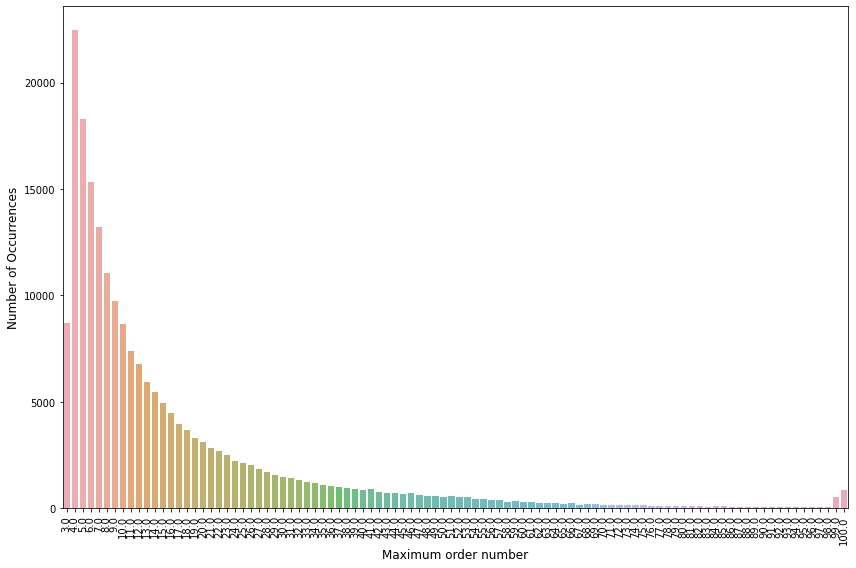

In [0]:
cnt_srs = log.groupby('user_id').max('order_number').withColumnRenamed('max(order_number)','order_number').drop('user_id')
cnt_srs = cnt_srs.toPandas()
cnt_srs = cnt_srs.order_number.value_counts()

plt.figure(figsize=(12, 8))
sns.barplot(cnt_srs.index, cnt_srs, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Maximum order number', fontsize=12)
plt.xticks(rotation='vertical')
plt.tight_layout()
plt.show()

There are no orders less than 4 and is max capped at 100 as given in the data page.

Now let us see how the ordering habit changes with day of week.

In [0]:
log = log.withColumn('days_since_prior_order', fn.col('days_since_prior_order').astype(IntegerType()))
data = log.toPandas()

/databricks/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
 warnings.warn(

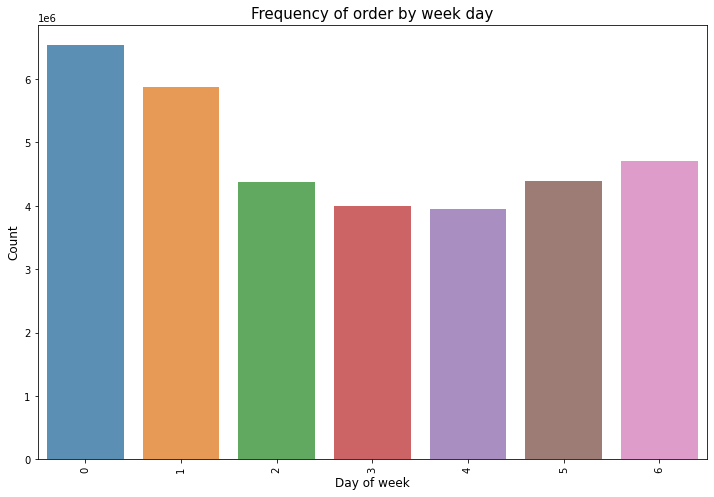

In [0]:
dow_srs = data.order_dow.value_counts().sort_index()
#dow_srs.head()

plt.figure(figsize=(12, 8))
#sns.countplot(x="order_dow", data=data)
sns.barplot(dow_srs.index, dow_srs, alpha=0.8)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of order by week day", fontsize=15)
plt.show()

Seems like 0 and 1 is Saturday and Sunday when the orders are high and low during Wednesday.

Now we shall see how the distribution is with respect to time of the day.

/databricks/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
 warnings.warn(

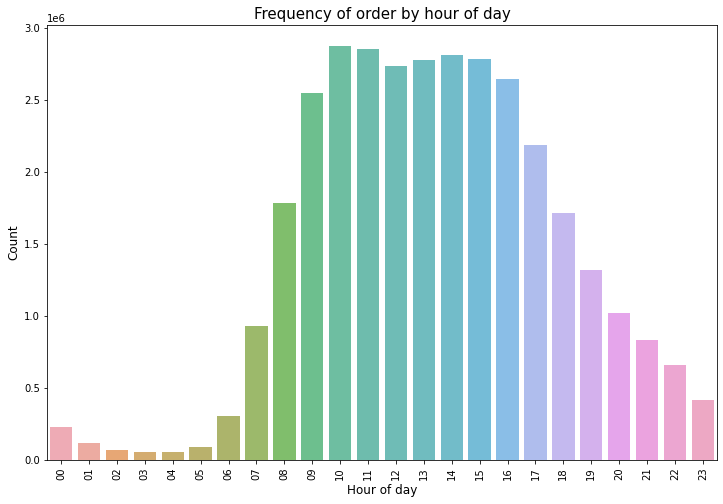

In [0]:
hour_srs = data.order_hour_of_day.value_counts().sort_index()

plt.figure(figsize=(12, 8))
sns.barplot(hour_srs.index, hour_srs, alpha=0.8)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of order by hour of day", fontsize=15)
plt.show()

So majority of the orders are made during day time. Now let us combine the day of week and hour of day to see the distribution.

Now let us check the time interval between the orders.

/databricks/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
 warnings.warn(

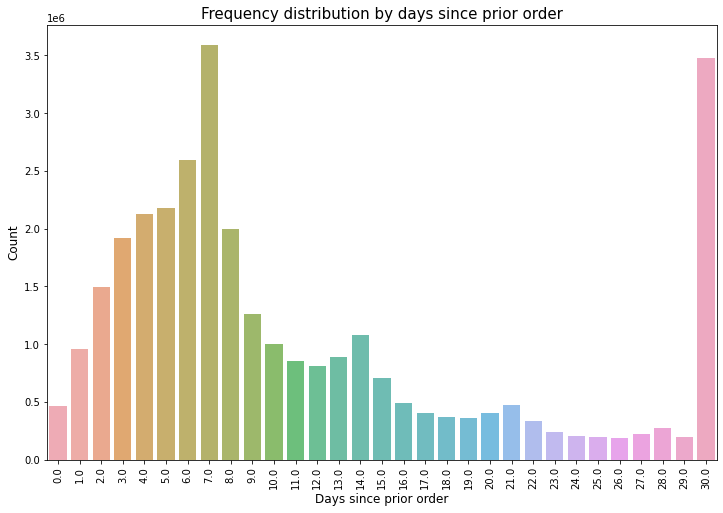

In [0]:

days_prior_srs = data.days_since_prior_order.value_counts().sort_index()

plt.figure(figsize=(12, 8))
sns.barplot(days_prior_srs.index, days_prior_srs, alpha=0.8)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Days since prior order', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency distribution by days since prior order", fontsize=15)
plt.show()

Looks like customers order once in every week (check the peak at 7 days) or once in a month (peak at 30 days). We could also see smaller peaks at 14, 21 and 28 days (weekly intervals).

Now let us move on to product.

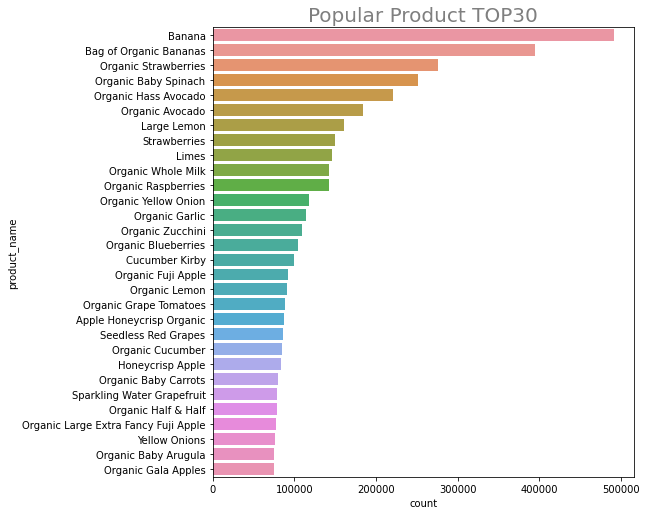

In [0]:

df = log.groupby('product_name').count().orderBy(['count'], ascending = [False]).toPandas()

fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.barplot(x='count', y='product_name', data=df.head(30), label='count')
plt.subplots_adjust(left=.4, right=.9)
plt.title('Popular Product TOP{0}'.format(30), fontsize=20, alpha=0.5)
plt.show()

Looks like Banana is the most popular product in Instacart. But we should know if this item is purchased by same user or not.

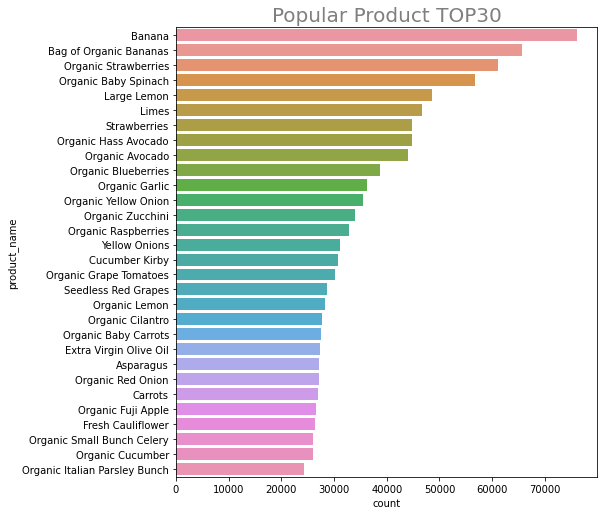

In [0]:
df = log.dropDuplicates(['user_id', 'product_id']).groupby('product_name').count().orderBy(['count'], ascending = [False]).toPandas()
# df = log.drop_duplicates(['user_id', 'product_id']).groupby('product_name').size().sort_values(ascending=False).to_pandas().to_frame().reset_index()
# df.columns = ['product_name', 'count']

fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.barplot(x='count', y='product_name', data=df.head(30), label='count')
plt.subplots_adjust(left=.4, right=.9)
plt.title('Popular Product TOP{0}'.format(30), fontsize=20, alpha=0.5)
plt.show()

This graph shows us that banana are loved by everyone. Over 70k users bought bananas.

### 3. Feature Engineering
If Exploratory Data Analysis is the most important part of our data science workflow, Feature Engineering is a close second. This is where we identify which features should be fed into the model and create features where we belive they might be able to help the model do a better job of predicting.

Below, we'll start by just identifying our unique User X Item combintations and sorting them.

In [0]:
print(log.count())
print(len(log.columns))
log.show(10)

33819106
15
+--------+-------+----------+-----------------+---------+--------+-------------+--------------------+--------+------------+---------+-----------------+----------------------+----------------+----------------------+
order_id|user_id|product_id|add_to_cart_order|reordered|aisle_id|department_id| product_name|eval_set|order_number|order_dow|order_hour_of_day|days_since_prior_order|order_number_inv|add_to_cart_order_norm|
+--------+-------+----------+-----------------+---------+--------+-------------+--------------------+--------+------------+---------+-----------------+----------------------+----------------+----------------------+
 925245| 165145| 47380| 33.0| 0| 15| 12|New York Style No...| train| 5.0| 2| 13| 21| 0.0| 0.7021276595744681|
 925245| 165145| 45763| 38.0| 1| 83| 4|Mini Seedless Cuc...| train| 5.0| 2| 13| 21| 0.0| 0.8085106382978723|
 925245| 165145| 12183| 40.0| 0| 36| 16|Butter Unsalted 4 ct| train| 5.0| 2| 13| 21| 0.0| 0.851063829787234|
 2735870| 196224| 9076| 2.0| 1| 116| 1| Blueberries| prior| 13.0| 6| 16| 1| 87.0| 0.6666666666666666|
 2735870| 196224| 7987| 1.0| 1| 88| 13|Hazelnut Spread w...| prior| 13.0| 6| 16| 1| 87.0| 0.3333333333333333|
 314137| 144189| 3848| 7.0| 0| 126| 11|Security Regular ...| prior| 1.0| 5| 19| null| 5.0| 0.5833333333333334|
 314137| 144189| 39451| 6.0| 0| 54| 17|Soft & Strong Bat...| prior| 1.0| 5| 19| null| 5.0| 0.5|
 314137| 144189| 45663| 9.0| 0| 121| 14|Honey Bunches of ...| prior| 1.0| 5| 19| null| 5.0| 0.75|
 314137| 144189| 45305| 8.0| 0| 129| 1|Taters Shredded P...| prior| 1.0| 5| 19| null| 5.0| 0.6666666666666666|
 414984| 11455| 38205| 6.0| 1| 4| 9| Cheddar Cheezy Mac| prior| 30.0| 5| 10| 5| 19.0| 0.42857142857142855|
+--------+-------+----------+-----------------+---------+--------+-------------+--------------------+--------+------------+---------+-----------------+----------------------+----------------+----------------------+
only showing top 10 rows

In [0]:
train = log.select(log.user_id, log.product_id).drop_duplicates().orderBy(['user_id', 'product_id'])
print(train.count())
print(len(train.columns))
train.show(10)

13863746
2
+-------+----------+
user_id|product_id|
+-------+----------+
 1| 10258|
 1| 10326|
 1| 12427|
 1| 13032|
 1| 13176|
 1| 14084|
 1| 17122|
 1| 196|
 1| 25133|
 1| 26088|
+-------+----------+
only showing top 10 rows

Next, we'll identify each user's last order number (using the previously created order_number_inv column) and using our orders dataset, append that to each user. This will create a dataset where each user maps to their most recent order number and on which day of week, at what hour during the day, and how many days it has been since that order.

In [0]:
df = (log.filter(log.order_number_inv==0)
         .select('user_id', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order')
         .dropDuplicates(['user_id']))
train = train.join(df, 'user_id','left')
print(train.count())
print(len(train.columns))
train.show(10)

13863746
6
+-------+----------+------------+---------+-----------------+----------------------+
user_id|product_id|order_number|order_dow|order_hour_of_day|days_since_prior_order|
+-------+----------+------------+---------+-----------------+----------------------+
 201436| 38248| 32.0| 5| 14| 25|
 192348| 19966| 14.0| 3| 14| 30|
 192348| 20114| 14.0| 3| 14| 30|
 192348| 20608| 14.0| 3| 14| 30|
 192348| 20995| 14.0| 3| 14| 30|
 192348| 21137| 14.0| 3| 14| 30|
 192348| 2179| 14.0| 3| 14| 30|
 201436| 34745| 32.0| 5| 14| 25|
 201436| 34969| 32.0| 5| 14| 25|
 201436| 35045| 32.0| 5| 14| 25|
+-------+----------+------------+---------+-----------------+----------------------+
only showing top 10 rows

Here, we'll identify the most recent orders for our users and products and create a column named label and assign that value to be 1. We'll then do a left merge using that dataset onto our training dataset and fill in all rows in the column label that are NA to be of value 0. In a way, we are creating our labels for our training dataset to be used later in our machine learning model. For each row, we can interpret these values to mean that:

- each value 0 means that that particular user did not order that particular item in their most recent order, and
- each value 1 means that that particular **did** order that particular item in their most recent order.

In [0]:
df = (log.filter(log.order_number_inv==0)
         .select('user_id', 'product_id')
         .withColumn('label', lit(1)))

train = train.join(df, ['user_id', 'product_id'], 'left').na.fill(0)
print(train.count())
print(len(train.columns))
train.show(10)

13863746
7
+-------+----------+------------+---------+-----------------+----------------------+-----+
user_id|product_id|order_number|order_dow|order_hour_of_day|days_since_prior_order|label|
+-------+----------+------------+---------+-----------------+----------------------+-----+
 186271| 25407| 38.0| 4| 21| 4| 0|
 79064| 24852| 37.0| 4| 11| 8| 0|
 137688| 15359| 18.0| 3| 19| 28| 0|
 19011| 28458| 31.0| 5| 07| 10| 0|
 36520| 46654| 6.0| 0| 16| 7| 1|
 106381| 35264| 15.0| 0| 14| 30| 0|
 121804| 33787| 14.0| 2| 15| 18| 0|
 146025| 28842| 49.0| 3| 17| 2| 0|
 144205| 39097| 12.0| 6| 10| 21| 0|
 144205| 38295| 12.0| 6| 10| 21| 0|
+-------+----------+------------+---------+-----------------+----------------------+-----+
only showing top 10 rows

Lastly, we'll use our `orders` dataset to identify which rows belong to the test dataset and we isolate them. This will result in our test dataset which will be used for submission purposes for Kaggle.

In [0]:
test = (orders.filter(orders.eval_set=='test')
              .join(log.select('user_id', 'product_id')
                       .dropDuplicates()
                       .orderBy(['user_id', 'product_id']),
                    'user_id',
                    'left'))
test = test.drop("order_id","eval_set")
print(test.count())
print(len(test.columns))
print(test.show(10))

4833292
6
+-------+------------+---------+-----------------+----------------------+----------+
user_id|order_number|order_dow|order_hour_of_day|days_since_prior_order|product_id|
+-------+------------+---------+-----------------+----------------------+----------+
 72621| 4| 4| 10| 30.0| 34590|
 72621| 4| 4| 10| 30.0| 43957|
 72621| 4| 4| 10| 30.0| 45946|
 72621| 4| 4| 10| 30.0| 21938|
 72621| 4| 4| 10| 30.0| 4824|
 72621| 4| 4| 10| 30.0| 15143|
 72621| 4| 4| 10| 30.0| 35176|
 72621| 4| 4| 10| 30.0| 43757|
 72621| 4| 4| 10| 30.0| 28874|
 72621| 4| 4| 10| 30.0| 11811|
+-------+------------+---------+-----------------+----------------------+----------+
only showing top 10 rows

None

#### 3.1. User Features
Now that we have created our `train` and `test` datasets, we will now create features for each of our users, each of our products, and each of our user x product combinations. Below, we create features for our users such as:

- How many kinds of product have user ordered?
- How many products have user ordered within one cart?
- Which department have user ordered products?
- When have user ordered products (day of week)?
- When have user ordered products (hour)?

We will do this for each of our `train` and `test` datasets.

In [0]:
def get_user_features(df):
  
  # How many kinds of product have user ordered?
  df_10 = df.select('user_id', 'product_id').dropDuplicates().groupby('user_id').count().withColumnRenamed('count','user_product_uq')

  # How many products have user ordered within one cart?
  df_11 = df.groupby('user_id', 'order_id').max('add_to_cart_order').groupby('user_id').min('max(add_to_cart_order)').withColumnRenamed('min(max(add_to_cart_order))', 'user_cart-pos_max_min')
  df_12 = df.groupby('user_id', 'order_id').max('add_to_cart_order').groupby('user_id').mean('max(add_to_cart_order)').withColumnRenamed('avg(max(add_to_cart_order))', 'user_cart-pos_max_mean')
  df_13 = df.groupby('user_id', 'order_id').max('add_to_cart_order').groupby('user_id').max('max(add_to_cart_order)').withColumnRenamed('max(max(add_to_cart_order))', 'user_cart-pos_max_max')
  df_14 = df.groupby('user_id', 'order_id').max('add_to_cart_order').groupby('user_id').agg(fn.percentile_approx("max(add_to_cart_order)", 0.5)).withColumnRenamed('percentile_approx(max(add_to_cart_order), 0.5, 10000)', 'user_cart-pos_max_median')
  df_15 = df.groupby('user_id', 'order_id').max('add_to_cart_order').groupby('user_id').agg(fn.stddev('max(add_to_cart_order)')).withColumnRenamed('stddev_samp(max(add_to_cart_order))', 'user_cart-pos_max_std')

  # Which departments have users ordered products?
  df_16 = df.crosstab('user_id', 'department_id')
  df_17 = df_16.select([fn.col(c).alias("user_department_"+c+"_freq") for c in df_16.columns]).withColumnRenamed('user_department_user_id_department_id_freq','user_id')

  df_18 = df.crosstab('user_id', 'department_id').withColumnRenamed("user_id_department_id", "user_id")
  if ' Red"' in df_18.columns:    #running on a CPU cluster, the crosstab generated a columnns called ' Red"', this did not occur on the GPU cluster
    df_18 = df_18.drop(' Red"')
    cols = [i for i in df_18.columns if not i=='user_id']
  else:
    cols = [i for i in df_18.columns if not i=='user_id']
  df_19 = (df_18.withColumn("SumCols",fn.expr('+'.join(cols))).select("user_id",*[fn.coalesce(fn.round(fn.col(i)/fn.col("SumCols"),2),fn.lit(0)).alias(i) for i in cols]).select([fn.col(c).alias("user_department_"+c+"_freq-norm") for c in df_18.columns]).withColumnRenamed('user_department_user_id_freq-norm','user_id'))

  # When have users ordered products(day of week)?
  df_20 = df.crosstab('user_id', 'order_dow')
  df_21 = df_20.select([fn.col(c).alias("user_order_dow_"+c+"_freq") for c in df_20.columns]).withColumnRenamed('user_order_dow_user_id_order_dow_freq','user_id')

  df_22 = df.crosstab('user_id', 'order_dow').withColumnRenamed("user_id_order_dow", "user_id")
  cols = [i for i in df_22.columns if not i=='user_id']
  df_23 = (df_22.withColumn("SumCols",fn.expr('+'.join(cols))).select("user_id",*[fn.coalesce(fn.round(fn.col(i)/fn.col("SumCols"),2),fn.lit(0)).alias(i) for i in cols]).select([fn.col(c).alias("user_order_dow_"+c+"_freq-norm") for c in df_22.columns]).withColumnRenamed('user_order_dow_user_id_freq-norm','user_id'))

  # When have user ordered products(hour)?
  df_24 = df.crosstab('user_id', 'order_hour_of_day')
  df_25 = df_24.select([fn.col(c).alias("user_order_hour_of_day_"+c+"_freq") for c in df_24.columns]).withColumnRenamed('user_order_hour_of_day_user_id_order_hour_of_day_freq','user_id')

  df_26 = df.crosstab('user_id', 'order_hour_of_day').withColumnRenamed("user_id_order_hour_of_day", "user_id")
  cols = [i for i in df_26.columns if not i=='user_id']
  df_27 = (df_26.withColumn("SumCols",fn.expr('+'.join(cols))).select("user_id",*[fn.coalesce(fn.round(fn.col(i)/fn.col("SumCols"),2),fn.lit(0)).alias(i) for i in cols]).select([fn.col(c).alias("user_order_dow_"+c+"_freq-norm") for c in df_26.columns]).withColumnRenamed('user_order_dow_user_id_freq-norm','user_id'))
  
  features = ( df_10.join(df_11, 'user_id', 'left')
                    .join(df_12, 'user_id', 'left')
                    .join(df_13, 'user_id', 'left')
                    .join(df_14, 'user_id', 'left')
                    .join(df_15, 'user_id', 'left')
                    .join(df_17, 'user_id', 'left')
                    .join(df_19, 'user_id', 'left')
                    .join(df_21, 'user_id', 'left')
                    .join(df_23, 'user_id', 'left')
                    .join(df_25, 'user_id', 'left')
                    .join(df_27, 'user_id', 'left'))
  return features
  

In [0]:
df = log.filter(log.order_number>0)
train_user_features = get_user_features(df)
print(train_user_features.count())
print(len(train_user_features.columns))

206209
111

In [0]:
test_user_features = get_user_features(log)
print(test_user_features.count())
print(len(test_user_features.columns))

206209
111

#### 3.2. Product Features
Below, we create features for our products such as:

- Which products are orders the most?
- Which products are ordered by the most unique users?
- When products are added, are they added first? Last? On average?
- When have user ordered products (day of week)?
- When have user ordered products (hour)?

We will do this for each of our `train` and `test` datasets.

In [0]:
def get_product_features(df):

  # Which products are ordered the most?
  df_10 = df.groupby('product_id').count().withColumnRenamed('count','product_size')

  # Which products are ordered by the most unique users?
  df_11 = df.groupby('product_id','user_id').count().groupby('product_id').count().withColumnRenamed('count','product_size_unq-user')

  # When products are added, are they added first? Last? On average?
  df_12 = df.groupby('product_id').max('add_to_cart_order').withColumnRenamed('max(add_to_cart_order)', 'product_cart-pos_max')
  df_13 = df.groupby('product_id').min('add_to_cart_order').withColumnRenamed('min(add_to_cart_order)', 'product_cart-pos_min')
  df_14 = df.groupby('product_id').mean('add_to_cart_order').withColumnRenamed('avg(add_to_cart_order)', 'product_cart-pos_mean')
  df_15 = df.groupby('product_id').agg(fn.percentile_approx("add_to_cart_order", 0.5)).withColumnRenamed('percentile_approx(add_to_cart_order, 0.5, 10000)', 'product_cart-pos_median')
  df_16 = df.groupby('product_id').agg(fn.stddev('add_to_cart_order')).withColumnRenamed('stddev_samp(add_to_cart_order)', 'product_cart-pos_std')

  df_17 = df.groupby('product_id').max('add_to_cart_order_norm').withColumnRenamed('max(add_to_cart_order_norm)', 'product_cart-pos-norm_max')
  df_18 = df.groupby('product_id').min('add_to_cart_order_norm').withColumnRenamed('min(add_to_cart_order_norm)', 'product_cart-pos-norm_min')
  df_19 = df.groupby('product_id').mean('add_to_cart_order_norm').withColumnRenamed('avg(add_to_cart_order_norm)', 'product_cart-pos-norm_mean')
  df_20 = df.groupby('product_id').agg(fn.percentile_approx("add_to_cart_order_norm", 0.5)).withColumnRenamed('percentile_approx(add_to_cart_order_norm, 0.5, 10000)', 'product_cart-pos-norm_median')
  df_21 = df.groupby('product_id').agg(fn.stddev('add_to_cart_order_norm')).withColumnRenamed('stddev_samp(add_to_cart_order_norm)', 'product_cart-pos-norm_std')

  # When have user ordered products(day of week)?
  df_22 = df.crosstab('product_id', 'order_dow')
  df_23 = df_22.select([fn.col(c).alias("product_order_dow_"+c+"_freq") for c in df_22.columns]).withColumnRenamed('product_order_dow_product_id_order_dow_freq','product_id')

  df_24 = df.crosstab('product_id', 'order_dow').withColumnRenamed("product_id_order_dow", "product_id")
  cols = [i for i in df_24.columns if not i=='product_id']
  df_25 = (df_24.withColumn("SumCols",fn.expr('+'.join(cols))).select("product_id",*[fn.coalesce(fn.round(fn.col(i)/fn.col("SumCols"),2),fn.lit(0)).alias(i) for i in cols]).select([fn.col(c).alias("product_order_dow_"+c+"_freq-norm") for c in df_24.columns]).withColumnRenamed('product_order_dow_product_id_freq-norm','product_id'))

  # When have user ordered products(hour)?
  df_26 = df.crosstab('product_id', 'order_hour_of_day')
  df_27 = df_26.select([fn.col(c).alias("product_order_hour_of_day_"+c+"_freq") for c in df_26.columns]).withColumnRenamed('product_order_hour_of_day_product_id_order_hour_of_day_freq','product_id')

  df_28 = df.crosstab('product_id', 'order_hour_of_day').withColumnRenamed("product_id_order_hour_of_day", "product_id")
  cols = [i for i in df_28.columns if not i=='product_id']
  df_29 = (df_28.withColumn("SumCols",fn.expr('+'.join(cols))).select("product_id",*[fn.coalesce(fn.round(fn.col(i)/fn.col("SumCols"),2),fn.lit(0)).alias(i) for i in cols]).select([fn.col(c).alias("product_order_hour_of_day_"+c+"_freq-norm") for c in df_28.columns]).withColumnRenamed('product_order_hour_of_day_product_id_freq-norm','product_id'))
  
  features = ( df_10.join(df_11, 'product_id', 'left')
                      .join(df_12, 'product_id', 'left')
                      .join(df_13, 'product_id', 'left')
                      .join(df_14, 'product_id', 'left')
                      .join(df_15, 'product_id', 'left')
                      .join(df_17, 'product_id', 'left')
                      .join(df_18, 'product_id', 'left')
                      .join(df_19, 'product_id', 'left')
                      .join(df_20, 'product_id', 'left')        
                      .join(df_21, 'product_id', 'left')
                      .join(df_23, 'product_id', 'left')
                      .join(df_25, 'product_id', 'left')
                      .join(df_27, 'product_id', 'left')
                      .join(df_29, 'product_id', 'left'))
  
  return features

In [0]:
df = log[log.order_number_inv>0]
train_product_features = get_product_features(df)

In [0]:
test_product_features = get_product_features(log)

#### 3.3. User X Product Features
Next, we create features for our user x product combinations such as:
- Has this user ordered this product at least once before?
- How many orders has a user placed that has included this item?

We will again do this for each of our `train` and `test` datasets.

In [0]:
def get_user_product_features(df):

  # Has this user ordered this product at least once before?
  min_ = df.agg(min("order_number_inv")).collect()[0][0]
  df_ = df.filter(df.order_number_inv == min_).select('user_id','product_id').withColumn('user_product_t-1', fn.lit(1))
  df_ = train.join(df_, ['user_id', 'product_id'], 'left').select('user_id','product_id','user_product_t-1').na.fill(0)

  # How many orders has a user placed that has included this item?
  df_2 = df.groupby('user_id','product_id').count().withColumnRenamed('count','user_product_size')

  features = df_.join(df_2, ['user_id', 'product_id'], 'left')
  
  return features

In [0]:
df = log[log.order_number_inv>0]
train_user_product_features = get_user_product_features(df)

In [0]:
test_user_product_features = get_user_product_features(log)

#### 3.4. Merge
Our last step is to take our `train` and `test` datasets and append to them our features about our users, our products, and our user x product combinations. After this, we'll be ready to build a model from our data!

In [0]:
train = train.join(train_user_features.drop('product_id'), 'user_id', 'left')
train = train.join(train_product_features,'product_id','left')
train = train.join(train_user_product_features, ['user_id', 'product_id'], 'left')

In [0]:
test = test.join(test_user_features.drop('product_id'), 'user_id', 'left')
test = test.join(test_product_features, 'product_id', 'left')
test = test.join(test_user_product_features, ['user_id', 'product_id'], 'left')

In [0]:
print(train.count())
print(len(train.columns))
train.show()

13863746
192
+-------+----------+------------+---------+-----------------+----------------------+-----+---------------+---------------------+----------------------+---------------------+------------------------+---------------------+----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+----------------------+-----------------------+-----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+---------------------------+----------------------------+----------------------------+----------------------------+----------------------------+----------------------------+----------------------------+----------------------------+----------------------------+----------------------------+----------------------------+---------------------------+----------------------------+----------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+--------------------------+--------------------------+--------------------------+--------------------------+--------------------------+--------------------------+--------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+------------+---------------------+--------------------+--------------------+---------------------+-----------------------+-------------------------+-------------------------+--------------------------+----------------------------+-------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------

In [0]:
print(test.count())
print(len(test.columns))
test.show()

4833292
191
+-------+----------+------------+---------+-----------------+----------------------+---------------+---------------------+----------------------+---------------------+------------------------+---------------------+----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+----------------------+-----------------------+-----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+---------------------------+----------------------------+----------------------------+----------------------------+----------------------------+----------------------------+----------------------------+----------------------------+----------------------------+----------------------------+----------------------------+---------------------------+----------------------------+----------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+--------------------------+--------------------------+--------------------------+--------------------------+--------------------------+--------------------------+--------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+------------+---------------------+--------------------+--------------------+---------------------+-----------------------+-------------------------+-------------------------+--------------------------+----------------------------+-------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+---------------------------------+------

### 4. Train and Predict
The mathematical operations underlying many machine learning algorithms are often matrix multiplications. These types of operations are highly parallelizable and can be greatly accelerated using a GPU. RAPIDS makes it easy to build machine learning models in an accelerated fashion while still using an interface nearly identical to Scikit-Learn and XGBoost.

There are many ways to create a model - one can use Linear Regression models, SVMs, tree-based models like Random Forest and XGBoost, or even Neural Networks. In general, tree-based models tend to work better with tabular data for forecasting than Neural Networks. Neural Networks work by mapping the input (feature space) to another complex boundary space and determining what values should belong to those points within that boundary space (regression, classification). Tree-based models on the other hand work by taking the data, identifying a column, and then finding a split point in that column to map a value to, all the while optimizing the accuracy. We can create multiple trees using different columns, and even different columns within each tree.

For a more detailed description of tree-based models XGBoost, see this fantastic documentation: https://xgboost.readthedocs.io/en/latest/tutorials/model.html

In addition to their better accuracy performance, tree-based models are very easy to interpet (important for when predictions or decisions resutling from the predictions have to be explained and justified, maybe for compliance and legal reasons e.g. finance, insurance, healthcare). Tree-based models are very robust and work well even when there's a small set of data points. Both attributes which are sometimes more difficult for complex models like Neural Networks.

In the section below, we'll set the different parameters for our XGBoost model and train 5 different models - each on a different subset of users so as to avoid overfitting to a particular set of users.

There are a number of parameters that can be set before XGBoost can be run.

- General parameters relate to which booster we are using to do boosting, commonly tree or linear model
- Booster parameters depend on which booster you have chosen
- Learning task parameters decide on the learning scenario. For example, regression tasks may use different parameters with ranking tasks.

For more information on the configurable parameters within the XGBoost module, see the documentation here: https://xgboost.readthedocs.io/en/latest/parameter.html

#### 4.1. Prepare Training Data

In [0]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer

index_cols = ['order_dow','order_hour_of_day', 'label']
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(train) for column in index_cols]
pipeline = Pipeline(stages=indexers)
train_indexed = pipeline.fit(train).transform(train).drop("order_dow","order_hour_of_day", "label")
train_indexed_no_nulls = train_indexed.na.drop()

In [0]:
train_df = train_indexed_no_nulls.toPandas()

#### 4.2. Prepare Test Data

In [0]:
index_cols = ['order_dow','order_hour_of_day']
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(test) for column in index_cols]
pipeline = Pipeline(stages=indexers)
test_indexed = pipeline.fit(test).transform(test).drop("order_dow","order_hour_of_day")
test_indexed_no_nulls = test_indexed.na.drop()

In [0]:
test_df = test_indexed_no_nulls.toPandas()

#### 4.3. Train the model on the training data

In [0]:
import xgboost as xgb

NFOLD = 5

PARAMS = {
    'max_depth':8, 
    'eta':0.1,
    'colsample_bytree':0.4,
    'subsample':0.75,
    'silent':1,
    'nthread':40,
    'eval_metric':'logloss',
    'objective':'binary:logistic',
    'tree_method':'gpu_hist'
         }

In [0]:
train_df['user_id'] = train_df['user_id'].astype('int64')

models = []
for i in range(NFOLD):
    train_ = train_df[train_df.user_id % NFOLD != i]
    valid_ = train_df[train_df.user_id % NFOLD == i]
    dtrain = xgb.DMatrix(train_.drop(['user_id', 'product_id', 'label_index'], axis=1).values, train_['label_index'])
    dvalid = xgb.DMatrix(valid_.drop(['user_id', 'product_id', 'label_index'], axis=1).values, valid_['label_index'])
    
    model = xgb.train(PARAMS, 
                      dtrain, 
                      1000, 
                      [(dtrain, 'train'),(dvalid, 'valid')],
                      early_stopping_rounds=50, 
                      verbose_eval=5)
    models.append(model)
    
    break

[23:57:37] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

 This could be a false alarm, with some parameters getting used by language bindings but
 then being mistakenly passed down to XGBoost core, or some parameter actually being used
 but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-logloss:0.62790	valid-logloss:0.62799
[5]	train-logloss:0.43234	valid-logloss:0.43278
[10]	train-logloss:0.34636	valid-logloss:0.34712
[15]	train-logloss:0.30475	valid-logloss:0.30570
[20]	train-logloss:0.28292	valid-logloss:0.28412
[25]	train-logloss:0.27034	valid-logloss:0.27180
[30]	train-logloss:0.26193	valid-logloss:0.26366
[35]	train-logloss:0.25805	valid-logloss:0.26000
[40]	train-logloss:0.25609	valid-logloss:0.25822
[45]	train-logloss:0.25484	valid-logloss:0.25715
[50]	train-logloss:0.25369	valid-logloss:0.25622
[55]	train-logloss:0.25279	valid-logloss:0.25550
[60]	train-logloss:0.25205	valid-logloss:0.25495
[65]	train-logloss:0.25156	valid-logloss:0.25463
[70]	train-logloss:0.25119	valid-logloss:0.25445
[75]	train-logloss:0.25077	valid-logloss:0.25417
[80]	train-logloss:0.25039	valid-logloss:0.25393
[85]	train-logloss:0.25013	valid-logloss:0.25381
[90]	train-logloss:0.24984	valid-logloss:0.25365
[95]	train-logloss:0.24953	valid-logloss:0.25346
[100]	train-logloss:0.24934	valid-logloss:0.25340
[105]	train-logloss:0.24905	valid-logloss:0.25326
[110]	train-logloss:0.24878	valid-logloss:0.25311
[115]	train-logloss:0.24862	valid-logloss:0.25305
[120]	train-logloss:0.24836	valid-logloss:0.25292
[125]	train-logloss:0.24817	valid-logloss:0.25284
[130]	train-logloss:0.24798	valid-logloss:0.25277
[135]	train-logloss:0.24779	valid-logloss:0.25267
[140]	train-logloss:0.24757	valid-logloss:0.25256
[145]	train-logloss:0.24741	valid-logloss:0.25252
[150]	train-logloss:0.24726	valid-logloss:0.25246
[155]	train-logloss:0.24707	valid-logloss:0.25239
[160]	train-logloss:0.24693	valid-logloss:0.25235
[165]	train-logloss:0.24678	valid-logloss:0.25230
[170]	train-logloss:0.24665	valid-logloss:0.25225
[175]	train-logloss:0.24651	valid-logloss:0.25224
[180]	train-logloss:0.24638	valid-logloss:0.25220
[185]	train-logloss:0.24627	valid-logloss:0.25218
[190]	train-logloss:0.24610	valid-logloss:0.25213
[195]	train-logloss:0.24597	valid-logloss:0.25207
[200]	train-logloss:0.24582	valid-logloss:0.25204
[205]	train-logloss:0.24572	valid-logloss:0.25202
[210]	train-logloss:0.24559	valid-logloss:0.25199
[215]	train-logloss:0.24547	valid-logloss:0.25197
[220]	train-logloss:0.24536	valid-logloss:0.25195
[225]	train-logloss:0.24525	valid-logloss:0.25193
[230]	train-logloss:0.24508	valid-logloss:0.25188
[235]	train-logloss:0.24498	valid-logloss:0.25185
[240]	train-logloss:0.24487	valid-logloss:0.25183
[245]	train-logloss:0.24475	valid-logloss:0.25179
[250]	train-logloss:0.24465	valid-logloss:0.25178
[255]	train-logloss:0.24455	valid-logloss:0.25177
[260]	train-logloss:0.24444	valid-logloss:0.25176
[265]	train-logloss:0.24435	valid-logloss:0.25175
[270]	train-logloss:0.24424	valid-logloss:0.25173
[275]	train-logloss:0.24414	valid-logloss:0.25171
[280]	train-logloss:0.24400	valid-logloss:0.25166
[285]	train-logloss:0.24391	valid-logloss:0.25165
[290]	train-logloss:0.24382	valid-logloss:0.25163
[295]	train-logloss:0.24371	valid-logloss:0.25162
[300]	train-logloss:0.24360	valid-logloss:0.25160
[305]	train-logloss:0.24349	valid-logloss:0.25156
[310]	train-logloss:0.24340	valid-logloss:0.25155
[315]	train-logloss:0.24329	valid-logloss:0.25152
[320]	train-logloss:0.24319	valid-logloss:0.25151
[325]	train-logloss:0.24310	valid-logloss:0.25151
[330]	train-logloss:0.24297	valid-logloss:0.25149
[335]	train-logloss:0.24287	valid-logloss:0.25147
[340]	train-logloss:0.24280	valid-logloss:0.25146
[345]	train-logloss:0.24272	valid-logloss:0.25146
[350]	train-logloss:0.24264	valid-logloss:0.25145
[355]	train-logloss:0.24257	valid-logloss:0.25146
[360]	train-logloss:0.24248	valid-logloss:0.25145
[365]	train-loglos

Since we're using 5 different models, we'll need to generate predictions for each of our models, add them all together, and divide by our number of models. This is a commonly used technique in forecasting called ensembling - it is very useful for avoiding overfitting and generating robust predictions that perform well in the real world.

In [0]:
pred = np.zeros(len(test_df))

In [0]:
for m in models:
  pred += m.predict(xgb.DMatrix(test_df.drop(['user_id', 'product_id'], axis=1).values))

pred /= len(models)

In [0]:
pred

Out[50]: array([0.0784995 , 0.00563407, 0.01154894, ..., 0.04769084, 0.12878413,
 0.1295121 ])

### 5. Feature Importance
Now that we've trained our models, we might want to take a look at the internal workings and understand which of the features we've crafted are contributing the most to the predictions. This is called Feature Importance. One of the advantages for tree-based models for forecasting is that understanding the different importances of our features is very easy.

Once we understand how our features contribute to the model accuracy, we can choose to remove features that aren't important or try to iterate and create new features, re-train, and re-assess if those new features are more important. Ultimately, being able to iterate quickly and try new things in this workflow will lead to the most accurate model and the greatest ROI (for forecasting, oftentimes cost-savings from reduced out-of-stock and poorly placed inventory).

Below, we write some convenience code to access the importance of the features in each model. We then pass in our list of models that we tained, iterate over them one by one, and average the importance of each variable across all the models. Lastly, we visualize the importances using a horizontal bar chart.

Below, we see specifically that 3 of our features are contributing the most to our predictions: :

- `user_product_size` - How many orders has a user placed that has included this item?
- `user_product_t-1` - Has this user ordered this product at least once before?
- `order_number` - The number of orders that user has created

All of this makes sense and aligns with our business understanding of the problem. Customers who have placed an order for an item before are more likely to repeat an order for that product, and users who place multiple orders of that product are even more likely to re-order. Additionally, the number of orders a customer has created correlates with their likelihood of re-ordering.

The below code uses the default XGBoost implementation of feature importance - but we are free to choose any implementation or technique. A wonderful technique (also developed by an NVIDIA Kaggle Grandmaster) is called LOFO.

LOFO (Leave One Feature Out) Importance calculates the importances of a set of features based on a metric of choice, for a model of choice, by iteratively removing each feature from the set, and evaluating the performance of the model, with a validation scheme of choice, based on the chosen metric.

LOFO first evaluates the performance of the model with all the input features included, then iteratively removes one feature at a time, retrains the model, and evaluates its performance on a validation set. The mean and standard deviation (across the folds) of the importance of each feature is then reported.

LOFO has several advantages compared to other importance types:

- It does not favor granular features
- It generalises well to unseen test sets
- It is model agnostic
- It gives negative importance to features that hurt performance upon inclusion
- It can group the features. Especially useful for high dimensional features like TFIDF or OHE features.

For more information on LOFO, see here: https://github.com/aerdem4/lofo-importance

In [0]:
def __get_imp__(model):
    for i in ['weight', 'gain', 'cover']:
        imp_ = model.get_score(importance_type=i)
        imp_ = pd.DataFrame(list(imp_.items()))
        imp_.columns = ['col',i]
        if i == 'weight':
            imp = imp_
        else:
            imp = pd.merge(imp, imp_, on='col', how='outer')
    imp.sort_values('gain', ascending=False, inplace=True)
    imp.set_index('col', inplace=True)
    return imp.fillna(0)

def get_imp(models):
    """
    models: list of model
    [model1, model2,...]
    or model
    
    return:
    averaged importance
    """
    if isinstance(models, list):
        for i,m in enumerate(models):
            if i==0:
                imp = __get_imp__(m)
            else:
                imp += __get_imp__(m)
        imp /= (i+1)
    else:
        imp = __get_imp__(models)
    
    imp.sort_values('gain',ascending=False,inplace=True)
    imp.reset_index(inplace=True)
    imp.columns = ['feature', 'weight', 'gain', 'cover']
    return imp

imp = get_imp(m)

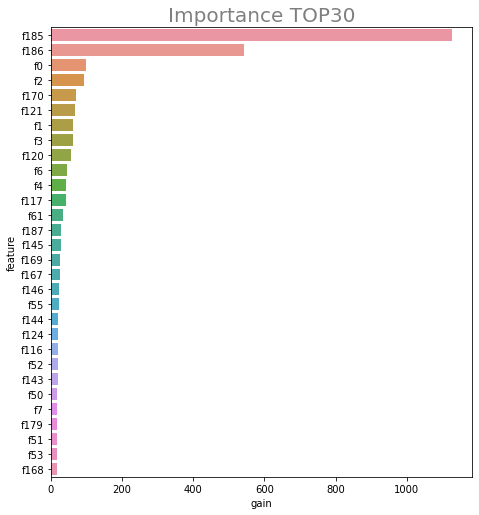

In [0]:
def plt_imp(imp, x='gain', y='feature', n=30, title='Importance'):
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    fig, ax = plt.subplots()
    # the size of A4 paper
    fig.set_size_inches(11.7, 8.27)
    sns.barplot(x=x, y=y, data=imp.head(n), label=x)
    plt.subplots_adjust(left=.4, right=.9)
    plt.title(title+' TOP{0}'.format(n), fontsize=20, alpha=0.5)
    plt.show()

plt_imp(imp)

### 6. Hyperparamater Optimization (HPO)
When we trained our XGBoost models, we used the following parameters:

`PARAMS = {`\
 `'max_depth':8,`\
  `'eta':0.1,`\
  `'colsample_bytree':0.4,`\
  `'subsample':0.75,`\
   `'silent':1,`\
   `'nthread':40,`\
   `'eval_metric':'logloss',`\
   `'objective':'binary:logistic',`\
   `'tree_method':'gpu_hist'`\
   `}`
         
Of these, only a few may actually be changed and effect the accuracy of our model: `max_depth`, `eta`, `colsample_bytree`, and `subsample`. However, these may not be the most optimal parameters. The art and science of identifying and training models with the model optimal hyperparamers is called hyperparameter optimization.

While there is no magic button one can press to automatically identify the most optimal hyperparameters, there are techniques that allow you to explore the range of all possible hyperparameter values, quickly test them, and find values that are closest.

A full exploration of these techniques is beyond the scope of this notebook. However, RAPIDS is integrated into many Cloud ML Frameworks for doing HPO as well as with many of the different open source tools. And being able to use the incredible speedups from RAPIDS allows you to go through your ETL, feature engineering, and model training workflow very quickly for each possible experiement - ultimately resulting in fast HPO explorations through large hyperparameter spaces and a significant reduction in Total Cost of Ownership (TCO).